In [1]:
from glob import glob
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
import torch
import torch.nn as nn
import torch.nn.functional

import torchvision
from torch.utils.data import TensorDataset
import math

from model import SwinUNet

In [2]:
def load_image(path, size):
    image = cv2.imread(path)
    image = cv2.resize(image, (size,size))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = image/255.
    return image

def load_data(root_path, size):
    images = []
    masks = []
    for path in sorted(glob(root_path)):
        for imgs in glob(path + '/*'):
            img = load_image(imgs, size)
            if 'images' in path:
                images.append(img)
            elif 'masks' in path:
                    img = np.array(img>0.5, dtype='float64')
                    masks.append(img)
   
    return np.array(images), np.array(masks)

In [3]:
size = 512
X_train, Y_train = load_data('./mydata/train/*', size)
X_valid, Y_valid = load_data('./mydata/valid/*', size)
X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape

((320, 512, 512), (80, 512, 512), (320, 512, 512), (80, 512, 512))

In [4]:
'''
Note always use pytorch transforms alongside dataloaders for image augmentation.
This is a crude way of doing thing.
'''

X_train = np.expand_dims(X_train,-1)
Y_train = np.expand_dims(Y_train,-1)

def elastic_transform(image, mask, alpha_affine):

    random_state = np.random.RandomState(None)
    shape = image.shape
    shape_size = shape[:2]

    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = 42#min(shape_size) // 3
    pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)
    mask = cv2.warpAffine(mask, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)
    return image, mask

def hflip_transform(image, mask):
    image = cv2.flip(image, 1)
    mask = cv2.flip(mask, 1)
    return image, mask

def vflip_transform(image, mask):
    image = cv2.flip(image, 0)
    mask = cv2.flip(mask, 0)
    return image, mask

def flip_transform(image, mask):
    image = cv2.flip(image, -1)
    mask = cv2.flip(mask, -1)
    return image, mask

el_train_images = [elastic_transform(img, mask, img.shape[1] * 0.04) for img,mask in zip(X_train,Y_train )]

hflip_train_images = [hflip_transform(img, mask) for img,mask in zip(X_train,Y_train )]

vflip_train_images = [vflip_transform(img, mask) for img,mask in zip(X_train,Y_train )]

flip_train_images = [flip_transform(img, mask) for img,mask in zip(X_train,Y_train )]


train_images_list = [el_train_images, hflip_train_images, vflip_train_images, flip_train_images]


for each_el_tf in train_images_list:
    el_tf_imgs,  el_tf_masks = zip(*each_el_tf)
    el_tf_imgs = list(el_tf_imgs)
    el_tf_masks = list(el_tf_masks)
    X_train = np.concatenate((X_train, np.expand_dims(el_tf_imgs, -1)))
    Y_train = np.concatenate((Y_train, np.expand_dims(el_tf_masks, -1)))

X_train = torch.from_numpy(np.float32(np.squeeze(X_train,-1))).unsqueeze(1)
Y_train = torch.from_numpy(np.float32(np.squeeze(Y_train,-1))).unsqueeze(1)
X_valid = torch.from_numpy(np.float32(X_valid)).unsqueeze(1)
Y_valid = torch.from_numpy(np.float32(Y_valid)).unsqueeze(1)
X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape

(torch.Size([1600, 1, 512, 512]),
 torch.Size([80, 1, 512, 512]),
 torch.Size([1600, 1, 512, 512]),
 torch.Size([80, 1, 512, 512]))

In [5]:
BATCH_SIZE = 4

train_loader = torch.utils.data.DataLoader(TensorDataset(X_train,Y_train), batch_size=BATCH_SIZE,
                                        shuffle=True)

valid_loader = torch.utils.data.DataLoader(TensorDataset(X_valid,Y_valid), batch_size=BATCH_SIZE,
                                        shuffle=True)

In [6]:
def compute_miou(pred, gt):
    TP = np.logical_and(pred == 1, gt == 1).sum()
    TN = np.logical_and(pred == 0, gt == 0).sum()
    FP = np.logical_and(pred == 1, gt == 0).sum()
    FN = np.logical_and(pred == 0, gt == 1).sum()

    # compute mean iou
    iou_p = TP / (TP + FP + FN) if (TP + FP + FN) != 0 else 0
    iou_n = TN / (TN + FP + FN) if (TN + FP + FN) != 0 else 0
    miou = (iou_p + iou_n) / 2

    return miou

def compute_dsc(pred, gt):
    TP = np.logical_and(pred == 1, gt == 1).sum()
    FP = np.logical_and(pred == 1, gt == 0).sum()
    FN = np.logical_and(pred == 0, gt == 1).sum()

    dice = (2 * TP) / (2 * TP + FP + FN) if (2 * TP + FP + FN) > 0 else 0
    return dice

In [7]:
def train_epoch(model, dataloader):
    model.train()
    losses= []
    for x, y in dataloader:
        optimizer.zero_grad()
        out = model.forward(x.to(DEVICE))
        loss = loss_fn(out, y.to(DEVICE)).to(DEVICE)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)
    
def validate_epoch(model, dataloader):
    model.eval()
    losses = []
    miou_score = []
    dice_score = []
    with torch.no_grad():
        for x, y in dataloader:
            out = model.forward(x.to(DEVICE))
            loss = loss_fn(out, y.to(DEVICE)).to(DEVICE)
            out = (out > 0.5).float()
            losses.append(loss.item())
            miou_score.append(compute_miou(out.cpu().detach().numpy(), y.cpu().detach().numpy()))
            dice_score.append(compute_dsc(out.cpu().detach().numpy(), y.cpu().detach().numpy()))
    return np.mean(losses), np.mean(miou_score), np.mean(dice_score)
    
def train(model, epochs, min_epochs, early_stop_count, schedular=None):

    best_valid_loss = float('inf')
    # EARLY_STOP = early_stop_count

    train_loss_list = []
    valid_loss_list = []
    valid_miou_list = []
    valid_dice_list = []
    
    for ep in range(epochs):
        train_loss = train_epoch(model, train_loader)
        if schedular:
            schedular.step()
        valid_loss, valid_miou, valid_dice = validate_epoch(model, valid_loader)

        print(f'Epoch: {ep}: train_loss={train_loss:.5f}, valid_loss={valid_loss:.5f}, valid_miou={valid_miou:.5f}, valid_dice={valid_dice:.5f}')
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
        valid_miou_list.append(valid_miou)
        valid_dice_list.append(valid_dice)
        # if ep>min_epochs:
        #     if(valid_loss < best_valid_loss):
        #         best_valid_loss = valid_loss
        #         EARLY_STOP = early_stop_count
        #     else:
        #         EARLY_STOP -= 1
        #         if EARLY_STOP <= 0:
        #             torch.save(model.state_dict(), './weights/model.pth')
        #             return train_loss, valid_loss, valid_miou, valid_dice
                    
    torch.save(model.state_dict(), './weights/model.pth')
    return train_loss_list, valid_loss_list, valid_miou_list, valid_dice_list

# Training

In [8]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SwinUNet(512,512,1,32,1,3,4).to(DEVICE)

for p in model.parameters():
    if p.dim() > 1:
            nn.init.kaiming_uniform_(p)
        
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# schedular = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.005, pct_start=0.25, epochs=50, steps_per_epoch=len(train_loader), three_phase=True)
schedular = torch.optim.lr_scheduler.CyclicLR(optimizer, max_lr=0.005, base_lr=0.001, step_size_up=10, step_size_down=10, cycle_momentum=False)
loss_fn = nn.BCEWithLogitsLoss()

train_loss, valid_loss, valid_miou, valid_dice = train(model, epochs=50, min_epochs=25, early_stop_count=5, schedular=schedular)

Epoch: 0: train_loss=0.23253, valid_loss=0.17395, valid_miou=0.62086, valid_dice=0.46471
Epoch: 1: train_loss=0.15286, valid_loss=0.13862, valid_miou=0.65817, valid_dice=0.53820
Epoch: 2: train_loss=0.11441, valid_loss=0.10459, valid_miou=0.75622, valid_dice=0.71027
Epoch: 3: train_loss=0.09273, valid_loss=0.10001, valid_miou=0.76447, valid_dice=0.72160
Epoch: 4: train_loss=0.09038, valid_loss=0.09916, valid_miou=0.74886, valid_dice=0.69718
Epoch: 5: train_loss=0.11537, valid_loss=0.12758, valid_miou=0.72412, valid_dice=0.66121
Epoch: 6: train_loss=0.08941, valid_loss=0.08508, valid_miou=0.79460, valid_dice=0.76608
Epoch: 7: train_loss=0.07540, valid_loss=0.08005, valid_miou=0.80882, valid_dice=0.78532
Epoch: 8: train_loss=0.07068, valid_loss=0.07431, valid_miou=0.81582, valid_dice=0.79512
Epoch: 9: train_loss=0.06815, valid_loss=0.07592, valid_miou=0.79872, valid_dice=0.77106
Epoch: 10: train_loss=0.06656, valid_loss=0.07849, valid_miou=0.83034, valid_dice=0.81551
Epoch: 11: train_los

# Test

In [11]:
from skimage import io
from PIL import Image
import os

def save_pred_image(pred, image_name, output_folder):
    pred = pred.squeeze().cpu().numpy()
    pred_img = Image.fromarray((pred * 255).astype(np.uint8))

    # Save the image
    pred_filename = os.path.join(output_folder, image_name)
    pred_img.save(pred_filename)

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((512,512)),
    torchvision.transforms.ToTensor()
])

class TestDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, size, transform=None):
        self.image_path = image_paths
        self.transform = transform
        self.size = size
        self.test_images = torch.from_numpy(np.array([load_image(i, size) for i in image_paths]).astype('float32')).unsqueeze(1)
    def __len__(self):
        return len(self.image_path)
    def __getitem__(self, index):
        test = self.test_images[index]
        return {"img" : test, "filename": os.path.basename(self.image_path[index])}
        

test_loader = torch.utils.data.DataLoader(TestDataset(glob('./mydata/test/images/*.png'), 512, transform = transform), batch_size=1, shuffle=False)

output_folder = './mydata/test/preds/'

model.eval()

for test in test_loader:
    image = test['img'].to(DEVICE)
    filename = test['filename']
    
    outputs = model.forward(image)
    outputs = (outputs > 0.5).float()

    # Make sure output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Save predicted images
    save_pred_image(outputs[0], filename[0], output_folder)

# Plot

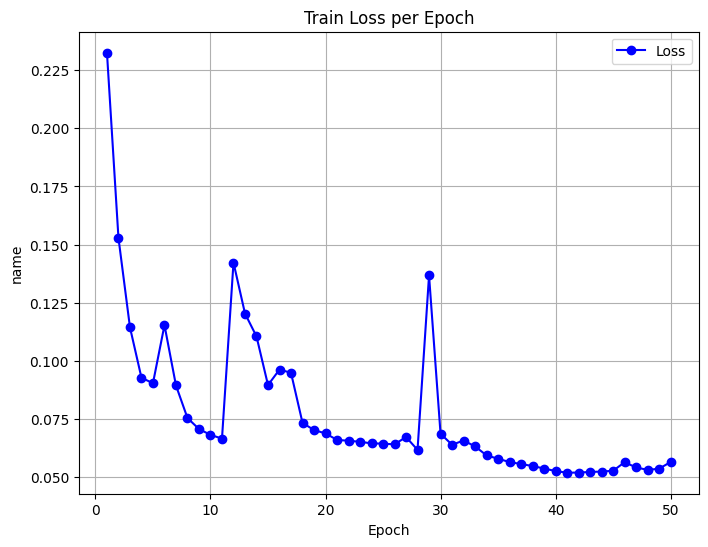

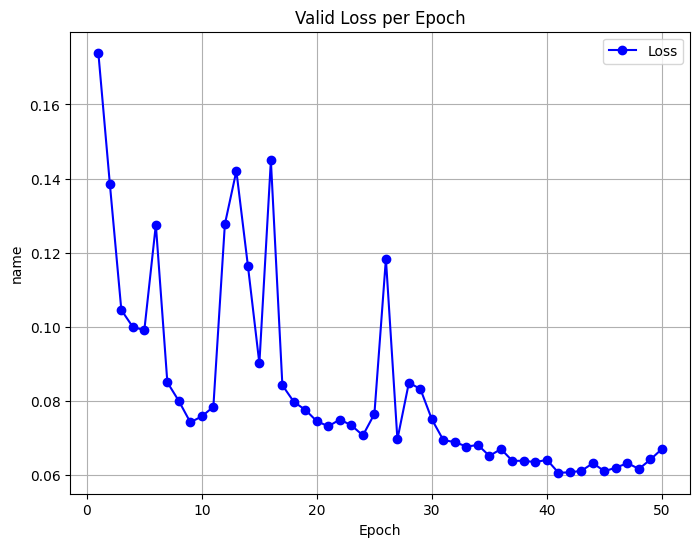

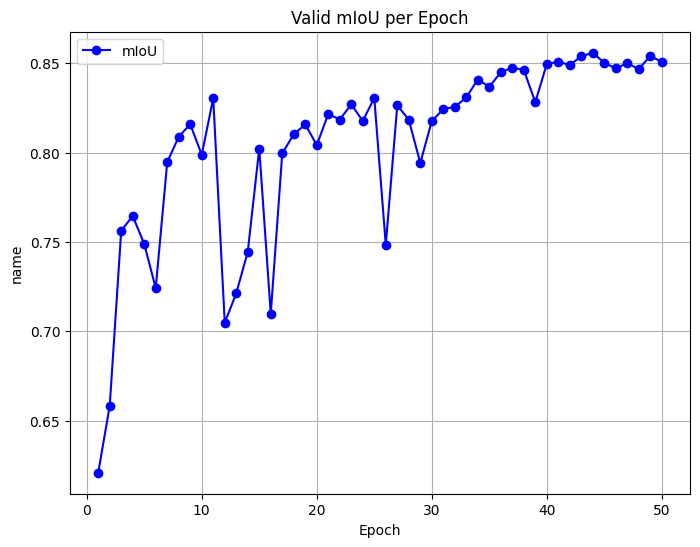

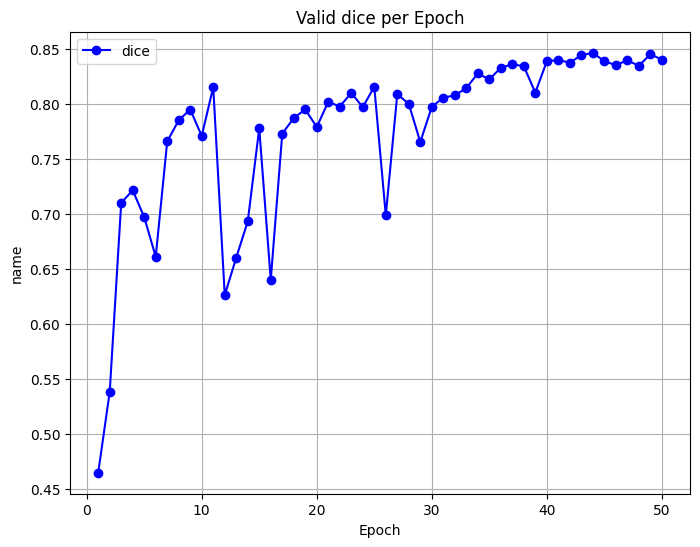

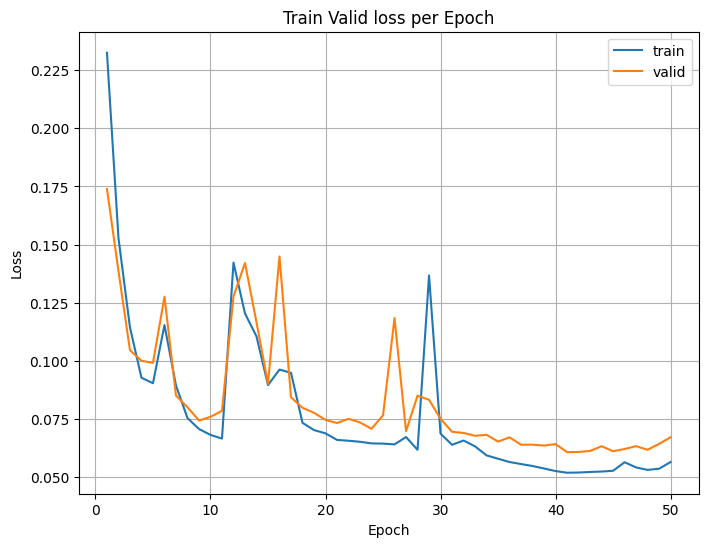

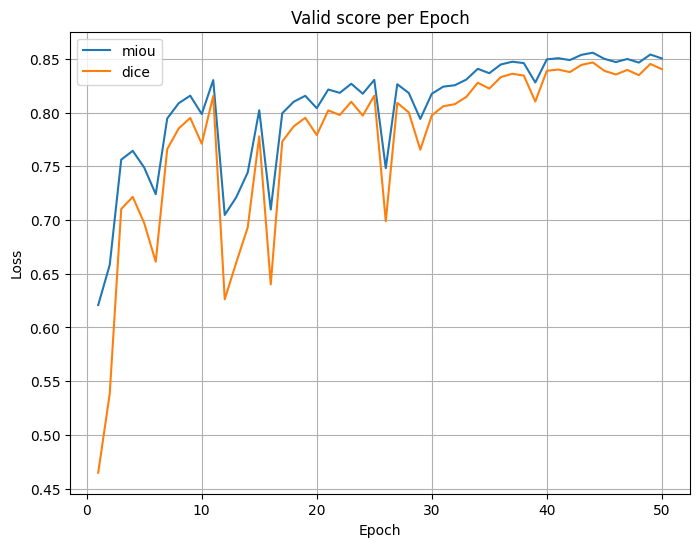

In [9]:
import matplotlib.pyplot as plt

bs = 4
ep = 50
size = 512
ws = 8

def plot(score, mode, name):
    plt.figure(figsize=(8,6))
    plt.plot(range(1, len(score)+1), score, marker='o', linestyle='-', color='b', label=f'{name}')
    plt.xlabel('Epoch')
    plt.ylabel(f'name')
    plt.title(f'{mode} {name} per Epoch')
    plt.legend()
    plt.grid()
    plt.savefig(f'./figure/{mode}_{name}_bs{bs}_ep{ep}_{size}_ws{ws}_CLRtri10.png')
    plt.show()

def plot_loss(tl, vl):
    plt.figure(figsize=(8,6))
    plt.plot(range(1, len(tl)+1), tl, linestyle='-', label='train')
    plt.plot(range(1, len(vl)+1), vl, linestyle='-', label='valid')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Train Valid loss per Epoch')
    plt.legend()
    plt.grid()
    plt.savefig(f'./figure/train_valid_loss_bs{bs}_ep{ep}_{size}_ws{ws}_CLRtri10.png')
    plt.show()

def plot_score(vm, vd):
    plt.figure(figsize=(8,6))
    plt.plot(range(1, len(vm)+1), vm, linestyle='-', label='miou')
    plt.plot(range(1, len(vd)+1), vd, linestyle='-', label='dice')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Valid score per Epoch')
    plt.legend()
    plt.grid()
    plt.savefig(f'./figure/valid_score_bs{bs}_ep{ep}_{size}_ws{ws}_CLRtri10.png')
    plt.show()

plot(train_loss, 'Train', 'Loss')
plot(valid_loss, 'Valid', 'Loss')
plot(valid_miou, 'Valid', 'mIoU')
plot(valid_dice, 'Valid', 'dice')
plot_loss(train_loss,valid_loss)
plot_score(valid_miou,valid_dice)

In [10]:
print('Train Loss', train_loss[-1])
print('Valid Loss', valid_loss[-1])
print('Valid mIoU', valid_miou[-1])
print('Valid dice', valid_dice[-1])

Train Loss 0.0564734280668199
Valid Loss 0.0671347115188837
Valid mIoU 0.850504109618307
Valid dice 0.8405159857696397
